In [1]:
import sys
import os
import uproot

# Añade el directorio padre al sys.path
sys.path.append(os.path.abspath("/mnt/netapp2/Store_uni/home/usc/ie/dcr/software/hk"))

# ROOT!
import os, sys
os.environ["ROOTSYS"] = "/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/software/ROOT/ROOT_6.26.14/install"
sys.path.append(os.path.join(os.environ["ROOTSYS"], "lib"))

import hipy.hipy.pltext  as pltext
import matplotlib.pyplot as plt
import awkward           as ak
import numpy             as np
import pandas            as pd

from nHits_trigger.src.read_data          import nHits, read_mpmt_offsets
from WCTE_BRB_Data_Analysis.wcte.brbtools import sort_run_files, get_part_files

from tqdm import tqdm

pltext.style()

In [2]:
datapath="/mnt/lustre/scratch/nlsas/home/usc/ie/dcr/hk/nicf_data/data/"
filename="run_1767_signal_N20candidates_unfiltered.csv"
data = pd.read_csv(datapath+filename)

In [3]:
data

,event_id,hit_pmt_calibrated_times,hit_pmt_charges,hit_mpmt_card_ids,hit_mpmt_slot_ids,hit_pmt_channel_ids,hit_pmt_position_ids
0,0.0,53683.787124,117.0,108.0,3.0,14.0,13.0
1,0.0,53691.537798,100.0,102.0,22.0,10.0,10.0
2,1.0,63479.663380,83.0,12.0,1.0,15.0,5.0
3,1.0,63480.392541,133.0,36.0,46.0,13.0,12.0
4,1.0,63496.106182,180.0,96.0,8.0,15.0,5.0
...,...,...,...,...,...,...,...
8705717,1018209.0,376215.421834,53.0,76.0,86.0,17.0,15.0
8705718,1018210.0,433661.640903,432.0,109.0,104.0,11.0,11.0
8705719,1018210.0,433661.712431,366.0,109.0,104.0,13.0,12.0
8705720,1018211.0,468920.948412,126.0,33.0,83.0,16.0,14.0


In [4]:
#HISTOGRAMA DE CARGA TOTAL POR EVENTO, prueba1

#cada fila de datos es un hit=llega un fotón
#Evento: período de tiempo fijo en el que se recogen hits

In [ ]:
#1º) Agrupo los hits en sus respectivos eventos

# Tenemos 8705722 hits en total, pero queremos agruparlos en el evento en el que llegaron: evento 0, 1,..., 1018211 (event_id)

data_by_event=data.groupby("event_id") # .groupby("event_id") toma todas las filas con el mismo event_id y las junta en grupos

print(len(data_by_event)) #para ver cuántos grupos tengo uso len(); lo imprimo para verlo
#este es el nº de valores diferentes que tengo de event_id, que coincide con 0+1018211=1018211

1018212


In [6]:
#2º) Calculo la carga total en cada grupo (en cada evento): sumamos las cargas en cada grupo

total_charge_by_event=data_by_event["hit_pmt_charges"].sum() #data_by_event["hit_pmt_charges"] con los [] seleccionamos
#la columna hit_pmt_charges de cada grupo y luego sumamos sus valores
print(total_charge_by_event)

#==============CHATTY===========================================
# Busco los 30 eventos con más hits
top_30_charge=total_charge_by_event.nlargest(30) #crea una serie con los 30 valores más grandes de total_charge_by_event

print("="*60)
print("TOP 30 EVENTOS CON MÁS CARGA TOTAL")
print("="*60)

# Convertir a DataFrame con ranking desde 1
top_30_df = top_30_charge.reset_index()
top_30_df.columns = ['event_id', 'carga total']
top_30_df.index = top_30_df.index + 1
top_30_df.index.name = 'ranking'  # Nombre del índice

print(top_30_df)
#==============CHATTY===========================================

event_id
0.0            217.0
1.0            396.0
2.0           1037.0
3.0           3374.0
4.0            911.0
              ...   
1018207.0    23144.0
1018208.0     1050.0
1018209.0      723.0
1018210.0      798.0
1018211.0      369.0
Name: hit_pmt_charges, Length: 1018212, dtype: float64
TOP 30 EVENTOS CON MÁS CARGA TOTAL
         event_id  carga total
ranking                       
1        611631.0     395654.0
2        331213.0     383414.0
3         91436.0     312725.0
4        124589.0     281921.0
5        176854.0     274292.0
6        169735.0     260620.0
7          7344.0     251024.0
8        614335.0     246718.0
9        610497.0     245174.0
10       630248.0     241956.0
11       266779.0     241706.0
12       503363.0     238044.0
13       130010.0     236862.0
14        69008.0     236616.0
15       304875.0     233811.0
16       541663.0     230947.0
17       428841.0     230737.0
18       552441.0     227581.0
19       382035.0     227358.0
20       129341.0  

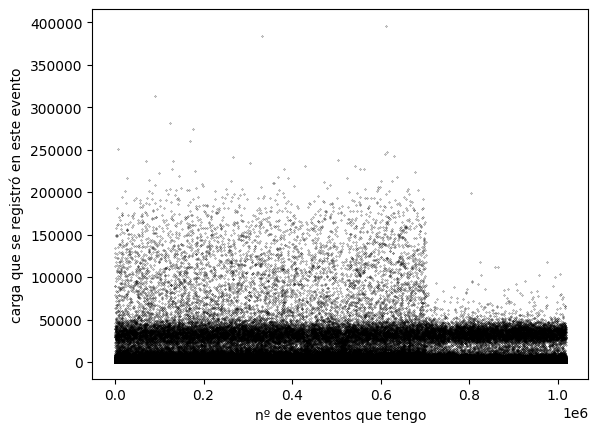

In [7]:
#3º) Puedo representar carga total vs grupo para visualizar cuánta carga se registró en cada evento

#Eje x= índice del grupo, data_by_event (desde 0 hasta 383768)
#Eje y= númeor de carga total dentro del grupo

plt.figure()
plt.scatter(total_charge_by_event.index, total_charge_by_event.values, s=0.05)
plt.xlabel("nº de eventos que tengo")
plt.ylabel("carga que se registró en este evento") #aquí no sé por qué pasa esto, debería haber sólo un valor??? creo q está bn así
plt.show()

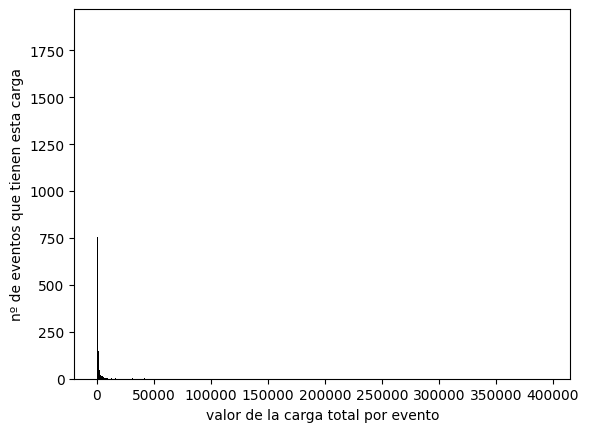

In [8]:
#4º) Ahora tengo que hacer el histograma

#usaremos: plt.hist(datos_que_queremos_graficar, bins=nº_de_barras)

charge=total_charge_by_event.values

#np.arange(charge.min(), charge.max()+2) crea un array que va desde el mínimo hasta el máx+2 de carga total por evento (por grupo)
#se le resta 0.5 para centrar las barras del histograma en los valores enteros

bins=np.arange(charge.min(), charge.max()+2) - 0.5 

plt.figure()
plt.hist(charge, bins)
plt.xlabel("valor de la carga total por evento")
plt.ylabel("nº de eventos que tienen esta carga")
plt.show()